In [1]:
import synotil;reload(synotil)
import synotil.util as sutil; reload(sutil)
import pymisca.util as pyutil; reload(pyutil)
import pymisca.vis_util as pyvis; reload(pyvis)
# reload(sutil.ctMat)
pd = pyutil.pd; np = pyutil.np; plt=pyutil.plt
%matplotlib inline

sfile = '/home/feng/envs/pipeline_Bd/bin/config_Bd21-3.sh'
pyutil.envSource(sfile,silent=1);

is in ipython: 1
[WARN] pymisca.vis_util cannot find network
[WARN] Cannot find file:key.gene
[WARN] Cannot find file:key.gene
is in ipython: 1
[WARN] pymisca.vis_util cannot find network


In [211]:
%time d3 = scount.vstack([d0,dd,dfix]*25,how='inner',as_index=0)
%time d3d = scount.vstack([d0,dd,dfix]*25,how='inner',as_index=1)


CPU times: user 1.05 s, sys: 52 ms, total: 1.1 s
Wall time: 1.1 s
CPU times: user 608 ms, sys: 8 ms, total: 616 ms
Wall time: 614 ms


In [43]:
import pymisca.vis_util as pyvis
??pyvis.discrete_cmap

[WARN] NUMPY is not limited cuz NCORE is not set
[WARN] pymisca.vis_util cannot find network


is in ipython: 1 
[WARN]No module named jinja2_util


In [4]:
! ls 

 ChIP-Seq.ipynb			'=panelPlot=dev.ipynb'
 chipShot.py			 PanelPlot.py
'=chipSummary=dev.ipynb'	'=panelPlot=test.ipynb'
 chipSummary.py			 preprocessor.ipynb
 combineTPM.py			 preprocessor.py
 CountMatrix.py			'=ptn=compile_meta.ipynb'
 dev__1010__IGV-chipShot.ipynb	 ptn.py
 dev__dio.ipynb			 qcmsg.py
 dev.ipynb			 qcplots.py
 dev__qcplots.ipynb		'=RNASeq=mergeHeat_CountMatrix.ipynb'
 dio.py				 roadmap.ipynb
 filterByCDS.py			 segmentBySD.py
 getCPM4STAR.py			 shot2html.py
 __init__.py			'=Tools=.ipynb'
 jobs.py			 uniqMaxCol.ipynb
 marker.md			 uniqMaxCol.py
 modelRoutine.py		 util.ipynb
 mp_test.ipynb			 util.py
 normalise_CPM.py		 WorkingNotes.ipynb
 norm.py


In [7]:
! rm .PanelPlot.py

In [ ]:
%%writefile PanelPlot.py
# reload(scount)

import synotil.CountMatrix as scount
from synotil.CountMatrix import *
import pymisca.vis_util as pyvis; reload(pyvis)
import pymisca.util as pyutil; reload(pyutil)
plt = pyvis.plt
# import matplotlib.pyplot as plt
import textwrap
import warnings
# import xlsxwriter
import operator


import biograpy
import Bio.SeqFeature
# reload(pyutil)
# pyutil.cluMap = pyutil.mpl.colors.ListedColormap(['r', 'g', 'b', 'y', 'w', 'k', 'm'])

def seqFeat2plotFeat(feat):
    '''Default transformation from seqFeature to biograpy.features
'''
    
    plotFeat = biograpy.features.GeneSeqFeature(
        feature= feat,
        arrowHeadLengthRelative=200,)
    plotFeat.Y = (feat.strand -0.5)/2.
#     -0.25
    plotFeat.height=0.5
#     plotFeat.cm_value = 1.
    return plotFeat

def guessLook(obj):
    '''Guess how DataFrame should be plotted from its shape
'''
    look = 'patch'
    if obj.shape[-1] > 1:
        look = 'matrix'
    else:                
        dtype = obj.dtypes.iloc[0] 
        if dtype == 'int':
            look = 'patch'
        elif dtype == 'bool':
            look = 'tick'
            
        elif dtype == 'object':
            look = 'text'
            
        else:
            look = 'fill'
            
    obj.look = look
    return look
import copy
def fixCluster(ele,**kwargs):
    ''' Fix a integer-type track into a color track
'''
    if isinstance(ele,pd.DataFrame):
        ele = ele[ele.columns[0]]
#     if ele.dtype.is_dtype('category'):
    if str(ele.dtype) == 'category':
        val = np.nan_to_num(ele.cat.codes) 
    else:
        val = np.nan_to_num(ele.values)
#         ele.fillna(0).values
    N = val.max() - val.min() + 1 
    if N==2:
        shuffle = 0
    else:
        shuffle = 1
    cmap = pyvis.discrete_cmap(N,'Spectral',shuffle = shuffle,seed=0)
    cmap.set_bad('black',1.)
    
    C = val - val.min(); 
#                     print C.shape
    C = np.ma.array ( C, mask=np.isnan(C))
#                     print C.shape
    cmat = cmap( C ).squeeze()
#     print cmat.shape
#     ele  =pd.DataFrame(cmat).set_index( ele.index)
#     ele.look = 'patch'
    if not isinstance(ele,scount.countMatrix):
        ele = scount.countMatrix(ele,
                                 **kwargs
                                )

    elenew = ele.setDF(pd.DataFrame(cmat).set_index( ele.index) )
    elenew['clu'] = ele.values; ele =elenew
#     ele.__dict__.update(kwargs)
#     ele.cmap = cmap
#     ele.look = 'patch'
    ele.columns  = [unicode(ele.name)] + list(ele.columns[1:])
    ele = scount.countMatrix(ele,
                             cmap = cmap,
                             look='patch',
                                 **kwargs
                                )
#     ele = ele.rename(columns={0:unicode(ele.name)},)
    return ele

# from matplotlib.ticker import NullFormatter

hide_axis = pyvis.hide_axis
hide_frame= pyvis.hide_frame

# ax.xaxis.set_major_formatter(NullFormatter())

def getPatchTicks(df,tol = 10):            
    gp = df.reset_index().groupby(df.columns[-1])
    m = gp.apply(lambda x: 

             pd.Series(
                 (x.index.values.mean(),len(x.index)) + pyutil.span(x.index.values) 
             ,index=['M','LEN','MIN','MAX'],
             ) 
            )
    m['tickthis'] = m.MAX - m.MIN + 1 < m.LEN + 10
    return m.loc[m.tickthis]

class panelPlot(list):
    '''Class to systematically render plots
'''
    @property
    def shape(self):
        return [x.shape for x in self]
    
    def __init__(self,lst, validate= 1, 
                 _compiled = False, 
                 orig = None,
                 index =None,
                 geneName = None,
                 names  =None,
                 figsize = None,
                 debug=0 ,xlim=None,
                 title = None,
                 show_axa=0,show_axc=1,
                 height_ratios = None,
                 width_ratios = [1, 8, 0.3],
                 tickMax=100,
                 header_rotation = 'horizontal',
                 showGrid=1,
                 indexMapper =  None,
                 *args,**kwargs):
        first = list(lst[0])
        if isinstance(first[0],str):
            if len(first) == 2:
                names, lst = zip(*lst)
        lst = [ scount.countMatrix(x)
               if not isinstance(x,scount.countMatrix)
               else x
               for x in lst
              ]
        super(panelPlot, self).__init__(lst)
        self.set_names(names)
#         for x in self:
#             x.cmap = None
        self.index = None
        self.validate() if validate else None
        self._compiled = _compiled
        self.orig = orig
        self.index = index
        self.indexMapper = indexMapper
        self.debug = debug
        self.geneName = geneName 
        self.DIR = '.'
        self.fig = {}
        self.figsize = figsize
        self.xlim = xlim
        self.title = title
        self.show_axa = show_axa
        self.show_axc = show_axc
        self.height_ratios = height_ratios
        self.width_ratios = width_ratios
        self.tickMax = tickMax
        self.header_rotation = header_rotation
        self.showGrid = showGrid
    def __getslice__(self, *args):
        '''To be extended to allow for easier subIndex
'''
        dct = self.__dict__
        self.__init__(
            super(panelPlot, self).__getslice__(*args),
            **dct)
        return self
    def setAttr(self,**kwargs):
        for k,v in kwargs.items():
            setattr(self,k,v)
        return self
        
    def validate(self,):
        for x in self:
            pass
#             assert hasattr(x,'render'),'element "%s" does not support render()' % x.__repr__()
        return True
    
    def _render(self, obj, axs= None, look = 'patch',
                figsize=[14,6],
                tickMax =None,
                show_axa=None,
                show_axc = None,
                shortName=0, **kwargs):
        '''[CORE]: Contains rendering methods for different types of data
'''
#         if tickMax 
        tickMax=self.tickMax if tickMax is None else tickMax
        if axs is None:
            fig, axs = plt.subplots(1,1,figsize=figsize,sharex='all')
#             ax = axs
            ax =axs
        else:
            ax = axs[1]
        if show_axa is None:
            show_axa = self.show_axa
        if show_axc is None:
            show_axc = self.show_axc
            
        
        header_rotation = self.header_rotation
        assert isinstance(obj, scount.countMatrix)
#         if show_axa:
        axa,axb,axc = axs
        axa.get_shared_y_axes().join(axa, axb)
        hide_axis(axa); 
        cmap  = plt.get_cmap()
#         else:
#             axb, axc = axs

        
#         #### [TEMP]
        if not show_axa:
            pyvis.hide_frame(axa);
#             pyvis.hideAxis(axa)
            pyvis.hide_ticks(axa);
        hide_frame(axc);hide_axis(axc); 
#         pyvis.hide_ticks(axc);
        
        vlim = obj.vlim
#         xticks = np.linspace(0,len(obj),20+1)
        xlines = np.linspace(0, len(obj), 20+1)
        axb.set_xticks(xlines, minor = True)
        xticks = None
        xticklabs = None
        xlim = None
        
        if look =='matrix':
            res = obj.heatmap(ax=axb,cname = None,vlim=obj.vlim)   
#             res = pyvis.heatmap(obj.values, vlim = vlim, 
#                                 ax=axb,cname = None)   
            if show_axc:
                plt.colorbar(mappable=res, cax = axc )
                axcy = axc.get_yaxis(); axcy.tick_right(); axcy.set_visible(True)
    
        elif look in ['patch']:
            df = obj.fillna(0); 
            res = pyvis.heatmap(
                df.values[None,:,:3].astype(float),
                ax=axb,
                cname=None,
#                 vlim = [None,None],
#                 vlim = [0,1]
            )           

            dftick = getPatchTicks(df,tol =10)
            if not dftick.empty:
                xticks = dftick.M.values
                xticklabs = dftick.index.values
#                 .astype(int)
                axb.get_xaxis().tick_top()
    
        elif look =='line':
            if obj.shape[0] == 1:
                obj = obj.transpose()
                
            res = axb.plot(obj.values, 'x')
            if vlim is not None:
                axb.set_ylim(vlim)
                
        elif look =='fill':
            if obj.shape[0] == 1:
                obj = obj.transpose()
#             print obj.index
            xs,ys = obj.index,obj.values.ravel()
#             xs,ys = range(len(obj)),obj.values.ravel()
            res = axb.plot(xs, ys, '-')
            axb.fill_between(xs, 0, ys, interpolate=True)
            if vlim is not None:
                axb.set_ylim(vlim)
            xlim = pyutil.span(obj.index.values)
            
                
        elif look == 'tick':
            color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            res = axb.vlines(np.nonzero(obj.fillna(False).values),
                              -1, 1,
                             colors = color,
                             linewidth = 0.5,
                             )
        elif look == 'text':
            objc = obj.reset_index(drop=True).dropna()
#             axb_ymid =  sum(axb.get_ylim())/2.
            axb_ymid = 0.
            axb.set_ylim(-1,1)
            def plotter(row):
                i,val = row.name, row[0]
                res = axb.text( i + 0. , axb_ymid, 
                         val,
                        horizontalalignment='center',
                        verticalalignment='center',
                        rotation='vertical',
                        size='large',
# #                          fontsize=1,
#                         transform=axb.transAxes
                        ) 
            objc.apply(plotter,axis=1)
            
        elif look == 'gtf':
            feats = obj.to_feats()
            assert self.xlim is not None
            xlim = self.xlim
            axb.set_xlim(xlim)
#             if self.debug:
#                 print ('[feats]',feats)
            i = -1
    
#             import pdb; pdb.set_trace()
        
            for i,feat in enumerate(feats):
                tlim, _, _ = pybio.add_transcript(feat,ax=axb,adjust_xlim = 0,
                                                  force=1, #### TBC can be dangerous
                                                  intronHeight=0.75,
                                                  exonHeight=1.0,
                                                 ycent=i,debug=self.debug,)  
#                 if self.debug:
#                     print ('[tlim]',tlim)
            axb.set_ylim(-0.5,i+0.5)
    
        elif look == 'feats':
            feats = obj.values.ravel()
            if isinstance(feats[0] ,Bio.SeqFeature.SeqFeature):
                feats = map(seqFeat2plotFeat, feats)
            for fi, feat in enumerate(feats):
                feat.draw_feature()
                map(axb.add_patch, feat.patches)
                feat.draw_feat_name()
                map(axb._add_text,feat.feat_name)

#             axb.set_xlim(0,10000)
            axb.set_ylim(-1.,1.)    
#         xlim = 
        xlim  =self.get_xlim(xlim=self.xlim)
        print ('[xlim]',xlim)
        axb.set_xlim(xlim)
        
        if self.debug:
            print ('[xlim,ylim]',axb.get_xlim(),axb.get_ylim())
            print ('[look]{look}\n[xticks]{xticks}\n[xticklabs]{xticklabs}'.format(**locals()))
            
        ##### set vertical grid if not ticking
        if (look not in ['tick','gtf','fill','patch']) & (self.showGrid) :
            axb.grid(color='black',axis='x',linestyle='--',which='minor')
        if xticks is not None:
            axb.set_xticks(xticks)
            axb.set_xticklabels(xticklabs)
#             axb.xaxis.set_ticks_position('bottom') 
        else:
            hide_axis(axb,which = 'x')
            
#         if look not in ['fill']:
        if 1:
            axb.set_ylabel('')
            hide_axis(axb,which='y');
        else:
            pass

        
        if show_axa:
            ############################################
            #### Add row label within each track #######
            ############################################
            if look in ['fill','float']:
                colnames = axb.get_yticks()
    #             colnames = ['%.3f'%x for x in np.linspace(*axb.get_ylim())]
                for i,col in enumerate(colnames):
                    axa.text(1., col,
                         str(col)[:10],
                         horizontalalignment='right',
                          verticalalignment='center',
                          clip_on=show_axa,
                          
                            )

            else:
                colnames = obj.colName_short() if shortName else obj.columns
                if len(colnames) < tickMax or tickMax==-1:
#                     pass
#                 else:
                    for i,col in enumerate(colnames):
                        axa.text(1., i,
                             str(col)[:25],
                             horizontalalignment='right',
                              verticalalignment='center',
                              clip_on=show_axa,
                                )
                        
#             res = axb.text( i + 0. , axb_ymid, 
#                          val,
#                         horizontalalignment='center',
#                         verticalalignment='center',
#                         rotation='vertical',
#                         size='large',
# # #                          fontsize=1,
# #                         transform=axb.transAxes
#                         )                         
#         colnames = obj.columns

        ### Add track name
        track_ax = axb if not show_axa else axa
        
        axb.yaxis.set_ticks([])
        if obj.name is not None and obj.name != 'None':
            trackName = pyutil.formatName(obj.name)
            if header_rotation =='horizontal':
#                 track_ax.text(-.0, sum(axa.get_ylim())/2.,
                track_ax.text(-.0, 0.5,
                         trackName,
                         rotation = 'horizontal',
#                          horizontalalignment='center',
#                           verticalalignment='bottom',
                              transform=track_ax.transAxes,
                         horizontalalignment='right',
                          verticalalignment='center',                 
                        )        
            elif header_rotation == 'vertical':
                track_ax.set_ylabel(trackName)
            track_ax.yaxis.set_visible(True); track_ax.yaxis.set_ticks([])
        if self.debug:
            print ('[axb.get_xticks()]%s' % axb.get_xticks())
#         hide_axis(axb,which = 'x')
#         pyvis.hide_ticks(axb)
#         pyvis.hi
        return axs

    def get_xlim(self,xlim=None, obj=None):
        #### allow self.xlim to override
        if self.xlim is not None:
            xlim = self.xlim

        elif xlim is None:
            assert obj is not None,'Need to supply a data frame to set index'
            if obj.index.is_numeric():
                xlim = pyutil.span(obj.index)
            else:
                xlim = [0-0.5,len(obj)-0.5]
        return xlim
    @property
    def mapped_index(self):
        if self.indexMapper is not None:
            mapper = dict(zip(self.index, self.index))
            mapper.update(self.indexMapper)
            res = map(mapper.get, self.index)
        else:
            res = self.index
        return res
#             self.index = 
#         self.index
    def namedIndex(self,index=None,geneName = None):
        index = self.index if index is None else index
        geneName = self.geneName if geneName is None else geneName
        if geneName is None:
            ind = list(index)
        else:
            assert isinstance(geneName,pd.DataFrame)
            res = geneName.reindex(index=index)
            ser = res.iloc[:,0]
            nidx = ser.isnull()
            ser[nidx] = ser.index[nidx]
            ind = list(ser)
#             res.loc[nidx, res.columns[0]] = res.index[nidx]
#             ind = res.iloc[:,0]
        return ind
            
        
    def autoFigsize(self):
        xsize = min(len(self.index)*0.25, 14)
        ysize = (len(self) + 1 )*1.5
        return [xsize,ysize]
        
    def render(self,  figsize= None,
              index=None, how = None, order = None,
               shortName=0,
#                tickMax=100,
               height_ratios = None,
#                width_ratios = None,
              silent= 1):
        tickMax = self.tickMax
        if height_ratios is None:
            height_ratios = self.height_ratios
            if height_ratios is None:
                height_ratios = map(operator.attrgetter('height'), self)
        if not self._compiled:
            self.compile(how = how,index = index, order =order)
        else:
#             print 'here'
            self.joinIndex(how=how) if how is not None else None
            self.orderBy(order=order) if order is not None else None
            
        figsize = figsize or self.figsize or self.autoFigsize()

        
        width_ratios = self.width_ratios
        if not self.show_axa:
            width_ratios[0] = 0.
#             width_ratios = [1, 8,  None]
#         else:
#             width_ratios = [0., 8, None]
        width_ratios[2] = self.show_axc * 0.15 
#         else:
#             ncol = 2
        fig,axsLst = plt.subplots(len(self),3,
                                  figsize=figsize,
#                                   sharex='col',
#                                   frameon = False,
                                  gridspec_kw={'width_ratios':width_ratios,
                                               'wspace':0.0,
                                               'hspace': 0. ,
                                               'height_ratios':height_ratios,
                                              })
        if len(self)==1:
            axsLst = axsLst[None,:]
#         if not isinstance(axsLst,pyutil.np.ndarray) else axsLst
        
#         plt.suptitle(title,y=0.95)    
        if self.xlim is None:
            self.xlim = self.get_xlim(xlim=self.xlim, obj=self[0])
        for i in range(len(self)):
            axs, ele = axsLst[i], self[i]            
#             ax = axs[1]
            assert ele.name !='test','Track name cannot be %s'% ele.name
            self._render(ele, axs=axs, look = ele.look,silent = silent,
                        shortName=shortName)
        if self.xlim is not None:
            axb = axsLst[-1][1]
            xticks = np.linspace(0, self.xlim[1], 20+1).astype(int)
            plt.sca(axb)
            plt.xticks(xticks, xticks, rotation = 'vertical')
            
        title = self.title
        if title is None:
            title = 'N=%d'%len(ele); 
        axsLst[0][1].set_title(title)
        
        L_index = self.index.__len__()
        if (L_index<=tickMax or tickMax==-1)and L_index!=1:
#             xticks = self.namedIndex()
            xticklabs = self.mapped_index
            ax = axsLst[-1][1]; plt.sca(ax)
#             ax.xaxis.set_major_formatter(mticker.FixedFormatter())
            plt.xticks(range(len(xticklabs)), xticklabs , rotation = 'vertical')

            if self.debug:
                print ('[xticklabs]',xticklabs)
                print ('[self.index]',self.index)
        self.fig['handle'] = fig
        return fig 
    
    def cache(self, cacheName = 'test', fig= None):
        fig = self.fig.get('handle',None) if fig is None else fig
        assert fig is not None
        if self.DIR == './':
            print '[WARN] self.DIR is defaulting to current directory'
        figName = '%s/src/%s.png'%(self.DIR,cacheName)
        self.check_DIR( pyutil.os.path.dirname(figName) )
        figMd = pyutil.showsavefig(fig= fig,fname=figName)
        self.fig['name'], self.fig['md'] = figName,figMd
        return (figName, figMd)
    def copy(self,deep = False):
        new = copy.copy(self)
        return new
    def compile(self,
                index = None, how = 'outer', order = None,
               silent=1):
        '''
index: Specify the data to be included. Inferred from joinIndex() if is None
    how: passed to joinIndex()
    order: passed to joinIndex()
'''
        if self.orig is None:
            self.orig = self.copy()
#         self.joinIndex(how=how) if how is not None else None
        self.index = self.index if self.index is not None else self.joinIndex(how=how, )
        if index is not None:
            self.index = pd.Index(self.index) & index
        self.orderBy(order=order) if order is not None else None        
            
        looks = [guessLook(ele) if not ele.look else ele.look for ele in self ]
        
        for i, ele in enumerate(self):
            if not silent:
                print 'Index:%d'% i,
                print 'look:', ele.look, len(ele)
#             if ele.look != 'gtf':
            if ele.isIndexed:
                ele = ele.setDF(ele.loc[self.index])
#                 ele = ele.reindex(self.index)
#             ele = ele.setDF(ele.reindex( self.index ))
            if looks[i] == 'patch':
                if ele.cmap is None:
                    ele = fixCluster(ele)
            if self.debug:
                print ('[eleIndex]',self.index)
            self[i] =  ele
        
        self._compiled = True
        return self
    def recompile(self,*args,**kwargs):
        orig = self.reset()
        orig.compile(*args,**kwargs)
        orig._compiled=False
        return orig
#         return {'index':index}
    
    def reset(self, orig =None):
        orig = orig or self.orig
        if orig is None and not self._compiled:
            print '[WARN] Trying to reset() a raw <panelPlot>'
            orig = self
        return orig
    
    def makeFirst(self,i=0):
        '''
Promote ith element to the starting of list
'''
        self.insert(0,self.pop(i))
        return self
    @property
    def indexedTracks(self):
#         lst = self
        lst = [] 
        for x in self:
            if not x.isIndexed:
#             if x.look in ['gtf','feats']:
                continue
            lst.append(x)
        return lst
    
    def joinIndex(self, how = None,):
        '''
order: A DataFrame which will be sorted to obatin the ordering      
'''
        if how is None:
            how = 'outer'
        if self.indexedTracks:
            idx = scount.vstack(self.indexedTracks, as_index = 1, how=how)
        else:
            warnings.warn('indexing using longest track')
            idx = pd.Index(range(max(map(len,self))))
            
        self.index = idx
        return idx
    def orderBy(self, order = None, how=None, head = None ):
        if self.index is None:
            idx = self.joinIndex(how=how)
        else:
            idx = self.index
            
        if order is not None:
            df = order.reindex(idx)
            pyutil.reset_columns(df)
            df = df.sort_values(by=list(df.columns),axis=0)
            self.index = idx = df.index
            
        if head is not None:
            idx = self.index[:head]
        self.index = idx
        return self.index
    def set_names(self,names):
        if names:
            it = iter(names)
            for i in range(len(self)):
                name = next(it,None)
                if name:
                    self[i].set_name( name)
        return self
    @property
    def bigTable(self,how = 'outer'):
        lst = [x.copy() for x in self]
        types = pyutil.flatSubset([x.name for x in self],keep='type')
        for i,dd in enumerate(lst):
#             print '[look]=',dd.look
            if dd.look =='patch':
#                 print '[A patch]'
                lst[i] = dd.setDF(dd[dd.columns[-1:]])
    
        for i,dd in enumerate(lst):
            if dd.name.find('type')!=-1:
                TYPE = pyutil.flatSubset([dd.name],keep='type')[0]
            else:
                TYPE = 'unknown'
            dd.columns = ['%s_%s'%(TYPE, col) for col in dd.columns]
            
        res = scount.vstack(lst, how=how)
        
        return res
    
    def splitTable(self,index=None):
        index = self.index if index is None else index
        lst = [x.reindex(self.index) for x in self]
        return lst
    
    def check_DIR(self,DIR = None):
        DIR = self.DIR if DIR is None else DIR
        pyutil.shellexec('mkdir -p %s'%DIR)
        return DIR
#     def emptyExcel(self,fname ='main.xlsx'):
#         ExcelFile= pd.ExcelWriter('%s/%s'%(self.DIR,fname), engine='xlsxwriter')
#         return ExcelFile
    def dump(self, ExcelFile = 'main.xlsx', sheetName = 'test',figName = None,
             saveClose = 1,
            ):
        figName = figName or self.fig.get('name', None) 
        self.check_DIR()
        if isinstance(ExcelFile, str):
            ExcelFile = self.emptyExcel(ExcelFile)
        self.bigTable.to_excel( ExcelFile, sheetName,index=True,)
        sheet_curr = ExcelFile.sheets[sheetName]
        if figName is not None:
            sheet_curr.insert_image(0, 7, figName)
        if saveClose:
            ExcelFile.save()
            ExcelFile.close()
        return ExcelFile
    
class geneList(scount.countMatrix):
    def __init__(self,C=None,colName=None,rowName=None,**kwargs):
        super(geneList,self).__init__(C=len(rowName) * [1],rowName=rowName, **kwargs)
        self.astype('int')
        

def renderByCluster(panel,clu,DIR = None, addClu = 0,ExcelFile = None):
    assert isinstance(panel,panelPlot)
    assert isinstance(clu, scount.countMatrix)
#     if panel._compiled:
#         panel = panel.reset()
#     if clu not in panel:
    clu = clu.reindex(panel.index)
    if addClu:
        assert 0,"addClu=1 is buggy"
        fixClu = fixCluster(clu)
        fixClu.set_name( 'type=cluster_%s'%fixClu.name)
        panel.append(fixClu)
    if DIR is not None:
        panel.check_DIR(DIR)
        panel.DIR = DIR
    if ExcelFile is not None:
        if isinstance(ExcelFile,str):
            if not ExcelFile.endswith('.xlsx'):
                ExcelFile = ExcelFile +'.xlsx'
            ExcelFile = panel.emptyExcel(ExcelFile) 
        else:
            pass
    it = pyutil.itertools.chain( [(-1, panel)], clu.groupby( clu.columns[0], ) )
    for ci, df in it:
#         print ci
        pp = panel.copy()
        print pp
#         print 'cmap',pp[-1].cmap
        pp.index = df.index
        pp.compile(index = df.index)
        pp.render()
        if ExcelFile is not None:
            sheetName =  'clu%03d'%ci
            pp.cache(sheetName)
            ExcelFile = pp.dump(ExcelFile = ExcelFile,sheetName = sheetName, saveClose=0)
    ExcelFile.save(); ExcelFile.close();
panelPlot.renderByCluster = renderByCluster
#         pp.bigTable()
#         plt.show()


In [196]:
!chmod 777 -R /home/feng/repos/BrachyPhoton/

In [188]:
reload(pyutil)
import synotil.CountMatrix as scount
scount.countMatrix.colName_short??

is in ipython: 1


In [127]:
# import openpyxl
# ws = openpyxl.load_workbook('main.xlsx')
# st = ws.worksheets[0]
# st.add_image(openpyxl.drawing.image.Image('./src/test.png'), 'A1')
# # ws.save?
# ws.save('main.xlsx')

In [123]:
# improt 
xlsxwriter.xmlwriter

In [105]:
import pymisca.util as pyutil
pyutil.showsavefig?

In [117]:
?pyutil.pd.ExcelWriter

In [ ]:
def dump(self,fname = None, sheetName = 'test',fig = fig):
    ExcelFile= pd.ExcelWriter('%s/main.xlsx'%self.DIR, engine='xlsxwriter')
            sheet_curr = ExcelFile.sheets[cluName]
    FFname = 'src/clu%03d.png'%(clu,)
    if fig is not None:
        FigMd = pyutil.showsavefig(fig= fig,fname=FFname)
            sheet_curr.insert_image(0, 7, FFname)

            gCur[['Gene Name']].to_csv('src/%s'%cluName,index=0,)
            dd.df.loc[gCur['Gene Name']].to_excel(ExcelFile,cluName,index=True,)                
    ExcelFile.save()
    ExcelFile.close()

In [107]:
import synotil

fname = '../PAIRWISE_COMPARE=NO_FC=1.0_QVALUE=0.05_TITLE=164C_36C_PVALUE=0.05/summary/Bd-ELF3-FLAG_S19_gene_list.txt'
df = geneList.from_DataFrame(fname = fname,ext='tsv')
chipPeak = df
        
# rnaseq = sutil.countMatrix.from_npy('../../bulkrna/Clust/round2/Bd_annotated_WK2_LD-SD_log2-1p.pk_stdPer=75_norm=identityNorm_genre=DPGMM_nClu=30_maxIt=250.npy')
fname = 'Bd_annotated_WK2_elf3KO-SD_log2-1p.pk_stdPer=0_norm=identityNorm_genre=DPGMM_nClu=25_maxIt=1000.npy'
rnaseq = scount.countMatrix.from_npy(fname)
rnaclu = rnaseq.sortedLabel().sort_values(0)

dd = rnaseq
a = panelPlot([
               rnaclu,
               chipPeak,
               dd.setDF(dd.iloc[:10000]),
               dd.setDF(dd.iloc[:,0:1]),
#                rnaclu.astype('float'),
              ])
print a.shape
# a.render()
# a.makeFirst(1)
# .render()
# a.calc_index()
# a.render(how='left',index = rnaclu.index, )
a.compile(how='left',
         order = vstack([chipPeak,rnaclu])
        )
# a.render()
# a.reset()
index0 = a.index
a.compile(index = a.index[:400])
a.render()

a.compile(index = a.index[:100])
a.render()

a = a.recompile(index=index0)
a.render()

NameError: name 'geneList' is not defined

In [794]:
ax.set_ylabel?

In [726]:
np.isnan(rnaclu_fixed.reindex(a.index).fillna(1).values).mean()

0.0

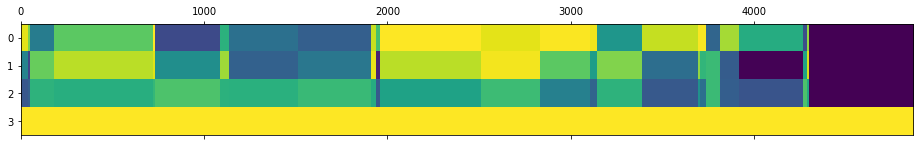

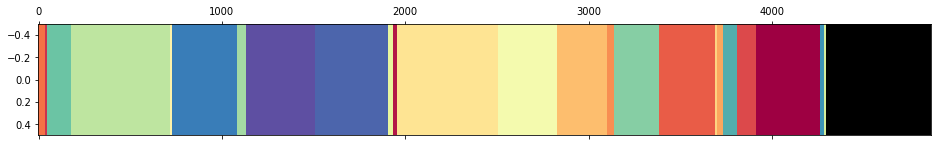

In [737]:
df = rnaclu_fixed.reindex(a.index).fillna(0)
df[3] = 1
plt.matshow(df.values[:].T,aspect='auto')
plt.matshow(df.values[None,:], aspect='auto')

In [67]:

def renderByCluster(panel,clu,addClu=1):
    assert isinstance(panel,panelPlot)
    assert isinstance(clu, countMatrix)
    if panel._compiled:
        panel = panel.reset()
#     if clu not in panel:
#     if not any([fixClu is x for x in panel]):
    if addClu:
        fixClu = fixCluster(clu)
        panel.append(fixClu)
    panel = panel.copy().compile(order=clu)
    panel.render()
    for ci, df in clu.groupby(clu.columns[0]):
#         print ci
        pp = panel.copy()
#         print 'cmap',pp[-1].cmap
        pp.index = df.index
        pp.compile(index = df.index)
        pp.render()

#         if ci ==5:
#             break

dfc =  rnaclu_fixed.copy()
dfc.look = 'matrix'
a = panelPlot([
               dd.setDF(dd.iloc[:10000]),
#                dd.setDF(dd.iloc[:,0:1]),
#                rnaclu_fixed,
#             rnaclu,
#                dfc,
               chipPeak,
#                rnaclu.astype('float'),
              ])
a0 = a
a0.orderBy(order=rnaclu)
# a0.compile(order=)
a0.render()
# a0.compile(index=a0.index[:1000])
# a0.render()
renderByCluster(a0.reset(),rnaclu)

NameError: name 'rnaclu_fixed' is not defined